<a href="https://colab.research.google.com/github/saerannn/ML-DL-Project/blob/main/Project_07_Building_Text_Summarization_Model_News_Article_Summarizer/%5BE07%5D_Building_Text_Summarization_Model_News_Article_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project_07_Building Text Summarization Model: News Article Summarizer**

# **1. 추상적 요약**
----

## **1-1. 데이터 불러오기 및 확인**
---

### **1-1-1. 라이브러리 불러오기**

In [204]:
############################################## 라이브러리 불러오기 #####################################################

# !pip install summa
import nltk
nltk.download('stopwords')
import requests
from summa.summarizer import summarize
import numpy as np
import pandas as pd
from locale import Error
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import requests
from summa.summarizer import summarize

from sklearn.model_selection import train_test_split
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **1-1-2. 데이터 불러오기**

In [205]:
############################################## 데이터불러오기 #####################################################
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data['Summary'] = data['headlines']
data = data.rename(columns={"['Text']":'Text'})
data['Text'] = data['text']
data = data[['Summary', 'Text']]
data

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


## **1-2. 데이터 전처리 (추상적 요약)**
---

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### **1-2-1. 중복 샘플과 NULL 값이 존재하는 샘플 제거**

In [206]:

############################################## 중복데이터갯수 출력 #####################################################

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())



############################################## 중복데이터 제거 #####################################################
data['Text'].drop_duplicates(inplace=True)
print('전체 샘플수 :', (len(data)))


Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98401



### **1-2-2. 결측데이터 확인**

In [207]:

############################################## 결측치 갯수 출력 #####################################################
print(data.isnull().sum())


############################################## 결측치 제거 #####################################################
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

Summary    0
Text       0
dtype: int64
전체 샘플수 : 98401



### **1-2-3. 텍스트 정규화와 불용어 제거**

> 텍스트를 정규화하는 방법은 다양한데 본 프로젝트에서는 직접 정규표현식을 사용해서 데이터 정규화를 진행하도록 하겠다. 전처리를 진행하는 내용은 다음과 같다. 
- 소문자 처리
- html 태그 제거
- 특수문자를 제거
- 괄호로 닫힌 문자열 (...) 제거 
- 쌍따옴표 " 제거
- 소유격 제거
- 약어 정규화
  - 링크의 게시글을 참고해 약어 정규화 사전을 생성했다.  [Expanding English language contractions in Python](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
- 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
- m이 3개 이상이면 2개로 변경



In [208]:

############################################## 약어를 정규화하는 사전 구성 #####################################################

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


############################################## 약어 정규화 사전수 확인  #####################################################
print("약어 사전의 수: ", len(contractions))

약어 사전의 수:  120


In [209]:

############################################## 정규화하는 함수 정의 #####################################################

def preprocess_sentence(df):
  try:
    df = df.applymap(str.lower) # 텍스트 소문자화
    df.replace(r'<[^>]*>', '', regex=True, inplace = True) # <br />, <a href = ...> 등의 html 태그 제거 
    df.replace(r'\([^)]*\)', '', regex=True, inplace = True) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for 
    df.replace('"','',regex=True, inplace = True)# 쌍따옴표 " 제거
    df.replace(contractions,regex=True, inplace = True) # 약어 정규화
    df.replace(r"'s\b","",  regex=True, inplace = True)# 소유격 제거. Ex) roland's -> roland
    df.replace("[^a-zA-Z]", " ", regex=True, inplace = True) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    df.replace('[m]{2,}', 'mm', regex=True, inplace = True) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah   
    
    return df 

  except Exception as e:
    print(e)


In [210]:
############################################## 데이터프레임 전체 전처리 #####################################################
import timeit
start = timeit.default_timer()

data = preprocess_sentence(data)
end=timeit.default_timer()
total = end - start
total

39.95053587500115

In [211]:
data

,Summary,Text
0,upgrad learner switches to career in ml al w...,saurav kant an alumnus of upgrad and iiit b p...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform ...
2,new zealand end rohit sharma led india matc...,new zealand defeated india by wickets in the...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customer...
4,have known hirani for yrs what if metoo claim...,speaking about the sexual harassment allegatio...
...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,a crpf jawan was on tuesday axed to death with...
98397,first song from sonakshi sinha noor titled ...,uff yeh the first song from the sonakshi si...
98398,the matrix film to get a reboot reports,according to reports a new version of the ...
98399,snoop dogg aims gun at clown dressed as trump ...,a new music video shows rapper snoop dogg aimi...


> 정규화 처리외에도 자연어 처리 성능을 높이는 방법 중 하나가 불용어를 제거하는것이다. 본 프로젝트에서는 NLTk에서 제공하는 불용어 리스트를 참고해서 불용어 제거처리하도록 하곘다. 우선 영어 불용어 리스트를 먼저 확인해보도록하겠다.

In [212]:
############################################## NLTk의 영어 불용어 확인  #####################################################
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

> NLTK에서 제공하고 있는 불용어는 179개라는 것을 알 수 있다. 이제 불용어 제거를 진행하도록 하겠다.  

In [213]:
##############################################  불용어 제거하는 함수 정의  #####################################################

# 불용어 제거 (Text)
def remove_stopwords(series):
  stop_words = stopwords.words('english') 
  stopwords_dict = {string : '' for string in stop_words}
  series.replace(stopwords_dict, regex=True)
  return series


In [214]:
############################################# Text컬럼  불용어 처리 #####################################################

data['Text']  = remove_stopwords(data['Text'])


# 전처리 후 출력
print("Text 전처리 후 결과: ", data['Text'] [:5])
print("===="*45)
print("Summary 전처리 후 결과: ", data['Summary'] [:5])

Text 전처리 후 결과:  0    saurav kant  an alumnus of upgrad and iiit b p...
1    kunal shah credit card bill payment platform  ...
2    new zealand defeated india by   wickets in the...
3    with aegon life iterm insurance plan  customer...
4    speaking about the sexual harassment allegatio...
Name: Text, dtype: object
Summary 전처리 후 결과:  0    upgrad learner switches to career in ml   al w...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india    matc...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs  what if metoo claim...
Name: Summary, dtype: object


> 전처리를 진행한 후 결측데이터가 존재하는지 한번 더 확인해주겠다. 전처리과정에서 문장의 모든 단어가 사라지는 경우가 생기기 때문이다. 

In [215]:
############################################## 결측치갯수 확인 #####################################################

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# 결측데이터 갯수 확인 
data.isnull().sum()

Summary    0
Text       0
dtype: int64

> 결측데이터가 생긴것을 확인할 수 있는데, 이런 샘플들은 제거해주도록 하겠다.

In [216]:
############################################## 결측치 삭제 #####################################################
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


### **1-2-4. 샘플의 최대 길이 정하기**

> 훈련에 사용할 샘플의 최대 길이를 구하기위해 Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해보도록 하겠다.

======================== [Text,Summary 길이 통계값 확인] 
  - 텍스트의 최소 길이 : 1
  - 텍스트의 최대 길이 : 72
  - 텍스트의 평균 길이 : 57.93326287334478
  - 요약의 최소 길이 : 1
  - 요약의 최대 길이 : 17
  - 요약의 평균 길이 : 9.48493409619821


========================= [Text,Summary 길이 시각화] 


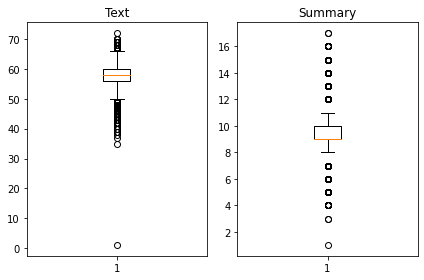

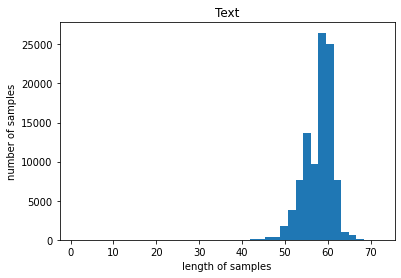

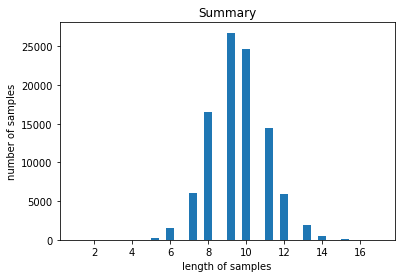

In [217]:
############################################## Text와 Summary 길이 통계값 출력 #####################################################

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print("{:=^75}".format(" [Text,Summary 길이 통계값 확인] \n"))
print('  - 텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('  - 텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('  - 텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('  - 요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('  - 요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('  - 요약의 평균 길이 : {}'.format(np.mean(summary_len)))


############################################## Text와 Summary  길이 시각화 #####################################################

print("\n\n{:=^75}".format(" [Text,Summary 길이 시각화] \n"))
# 실제 텍스트와 요약의 길이 분포 
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

#  실제 텍스트 샘플 길이별 개수
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 요약본 샘플 길이별 개수
plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
 - 텍스트의 최소 길이 : 1
  - 텍스트의 최대 길이 : 72
  - 텍스트의 평균 길이 : 57.93326287334478
  - 요약의 최소 길이 : 1
  - 요약의 최대 길이 : 17
  - 요약의 평균 길이 : 9.48493409619821


> 시각화 결과 Text의 최대길이와 ummary의 적절한 최대 길이를 확인 할 수 있어 train용 적정 길이를 설정할수있을것이다. 자세한건 아래에서 정리해보도록 하겠다.
- **Text**
  - 통계값: 최소 길이는 1, 최대 길이는 72, 평균 길이는 57이다. 
  - 시각화: 샘플길이는 대부분 50~65 사이에서 분포한다.  
- **Summary**
  - 통계값: 최소 길이가 1, 최대 길이가 17, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이 짧다. 
  - 시각화: 샘플길이는 대부분 6~14 사이에서 분포한다.   

In [227]:
################################## 위에서 파악한 값으로 임의로 값을 설정 ################################################
text_max_len = 70
summary_max_len = 12

> 임의로 값을 설정했는데 이것이 적당한 값인지 통계적으로 확인하는 과정을 진행하는것이 좋기에 이를 확인할 수 있는 함수를 정의하도록하겠다. 이후 이 함수의 파라미터로 임의로 설정한 Text와 Summary 최대길이값을 넣어 그 결과를 확인해보도록하겠다. 

In [228]:
################################## Text와 Summary 적절 길이를 파악하기위한 함수 정의 ################################################
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [229]:
################################## 임의로 설정한 값의 적절성 파악 ################################################
print("{:=^75}".format(" [Text] "))
below_threshold_len(text_max_len, data['Text'])
print(" \n {:=^75}".format(" [Text,Summary 길이 통계값 확인]"))
below_threshold_len(summary_max_len,  data['Summary'])

================================= [Text] ==================================
전체 샘플 중 길이가 70 이하인 샘플의 비율: 0.9999898375016514
 
 ========================= [Text,Summary 길이 통계값 확인]=========================
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.97556935396998


In [230]:
################################## 임의로 설정한 값 보다 길면 그 값을 제외 ################################################
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95997



### **1-2-5. 시작 토큰과 종료 토큰 추가**

> seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가 하는 과정이 필요하다. 요약데이터의 시작 토큰으로는 sostoken 을, 종료 토큰으로는 eostoken을 추가하도록 하겠다. 

In [231]:
################################## 요약 데이터에는 시작 토큰과 종료 토큰을 추가 ################################################

data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al w...,saurav kant an alumnus of upgrad and iiit b p...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al w...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform ...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india matc...,new zealand defeated india by wickets in the...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india matc...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan has deni...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [232]:

################################## 토큰을 추가한 데이터를 numpy형태로 저장 ################################################

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블



### **1-2-6. train test 데이터 생성**

> encoder_input과 크기와 형태가 같은 배열을 만들고 이를 섞어주면 잘 섞인  



In [233]:
X_train, X_test, y_train, y_test = train_test_split(data[['Text','decoder_input']],
                                                    data['decoder_target'],
                                                    test_size=0.2,
                                                    random_state=121)


encoder_input_train = np.array(X_train['Text'])
decoder_input_train = np.array(X_train['decoder_input'])
decoder_target_train = np.array(y_train)

encoder_input_test = np.array(X_test['Text'])
decoder_input_test = np.array(X_test['decoder_input'])
decoder_target_test = np.array(y_test)


print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76797
훈련 레이블의 개수 : 76797
테스트 데이터의 개수 : 19200
테스트 레이블의 개수 : 19200



### **1-2-7. 토큰화 및 텐서화**

> tf.keras.preprocessing.text.Tokenizer 패키지를 활용해서 토큰화하고, 단어 사전을 만들도록 하겠다.

In [234]:
##############################  데이터 토큰화를 위한 함수 정의  ############################## 


src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성



> 등장빈도수가 낮은 단어들은 훈련데이터에서 제외하고 진행하도록 하겠다.

In [235]:
##############################  등장횟수에 따른 빈도수   ############################## 


threshold = 7 #등장횟수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69392
등장 빈도가 6번 이하인 희귀 단어의 수: 47220
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22172
단어 집합에서 희귀 단어의 비율: 68.04818999308277
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.155002919948422


In [236]:

src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [237]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[372, 106, 359, 5449, 2657, 8, 10, 1775, 4, 241, 653, 6, 403, 970, 36, 4089, 264, 16, 53, 3890, 61, 5, 30, 6, 1, 109, 5, 1, 68, 3145, 1, 526, 9, 1719, 3890, 14, 10, 189, 1130, 377, 20, 970, 195, 55, 42, 77, 14, 67, 10, 640, 149, 25, 40, 6, 7795], [1012, 4829, 5, 49, 6237, 12, 6523, 15, 3, 2089, 664, 4036, 4, 653, 6, 403, 3450, 7, 136, 46, 1, 6447, 1339, 12, 26, 154, 15, 1, 399, 241, 84, 987, 11, 1, 229, 145, 324, 19, 14, 12, 257, 6238, 664, 1, 3146, 6, 1008, 417, 23, 3, 167, 5, 51, 11, 138, 60, 2, 620], [4721, 725, 385, 582, 958, 8, 865, 3, 332, 16, 3, 290, 87, 3163, 2, 672, 464, 1107, 5998, 2, 4223, 6, 305, 29, 526, 18, 1, 189, 174, 1855, 251, 5, 40, 127, 4223, 16, 1107, 4, 30, 18, 13, 164, 79, 2, 180, 2591, 9, 2175, 404, 305, 16, 1107, 3, 2358, 10]]


In [238]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [239]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29995
등장 빈도가 5번 이하인 희귀 단어의 수: 19638
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10357
단어 집합에서 희귀 단어의 비율: 65.47091181863644
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.697212608630798


In [240]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1351, 9, 4, 508, 168, 88], [1, 61, 430, 4, 797, 12, 1915], [1, 1074, 953, 3, 1973, 229, 1014], [1, 71, 666, 3, 1381, 1740, 541, 25, 510], [1, 1292, 1536, 743, 878, 743, 50, 280]]
target
decoder  [[1351, 9, 4, 508, 168, 88, 2], [61, 430, 4, 797, 12, 1915, 2], [1074, 953, 3, 1973, 229, 1014, 2], [71, 666, 3, 1381, 1740, 541, 25, 510, 2], [1292, 1536, 743, 878, 743, 50, 280, 2]]


In [241]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 13
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 76784
훈련 레이블의 개수 : 76784
테스트 데이터의 개수 : 19198
테스트 레이블의 개수 : 19198


### **1-2-8. 패딩 작업**

In [242]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')


## **1-3. 모델 설계하기**
---

### **1-3-1.인코더 설계**

In [243]:

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### **1-3-2. 디코더 설계**

In [244]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### **1-3-3. 디코더 출력층**

In [245]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 70, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 70, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

### **1-3-4. 어텐션 메커니즘 사용 (추상적 요약)**

In [246]:
from tensorflow.keras.layers import AdditiveAttention


# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 70, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 70, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            


## **1-4. 모델 훈련하기**
----

In [247]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 41s 101ms/step - loss: 3.9472 - val_loss: 3.6831
Epoch 2/50
300/300 [==============================] - 30s 99ms/step - loss: 3.5017 - val_loss: 3.3184
Epoch 3/50
300/300 [==============================] - 31s 102ms/step - loss: 3.1944 - val_loss: 3.0920
Epoch 4/50
300/300 [==============================] - 31s 105ms/step - loss: 2.9936 - val_loss: 2.9404
Epoch 5/50
300/300 [==============================] - 31s 104ms/step - loss: 2.8464 - val_loss: 2.8273
Epoch 6/50
300/300 [==============================] - 31s 104ms/step - loss: 2.7280 - val_loss: 2.7473
Epoch 7/50
300/300 [==============================] - 31s 104ms/step - loss: 2.6285 - val_loss: 2.6739
Epoch 8/50
300/300 [==============================] - 31s 104ms/step - loss: 2.5413 - val_loss: 2.6114
Epoch 9/50
300/300 [==============================] - 31s 104ms/step - loss: 2.4649 - val_loss: 2.5632
Epoch 10/50
300/300 [==============================] - 31s 105ms/step - lo

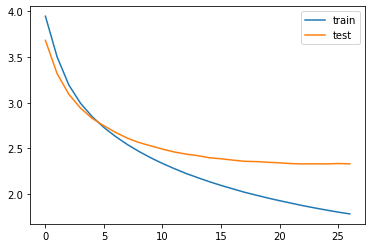

In [248]:
############################### loss 시각화 ################################# 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## **1-5. 인퍼런스 모델 구현**
---

In [249]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음



In [250]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [251]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [252]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


# **2. 추상적모델 vs 추출적모델**
---

> 이때까지 추상적요약모델을 생성했는데, 이 추상적요약과 추출적요약이 어떻게 다른지 출력해보도록 하겠다.

In [253]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [304]:
for i in range(50, 100):
    txt = data["Text"][i]
    print("원문 :", txt)
    print("실제 요약 :", seq2summary(decoder_input_test[i]))

    print("예측_추상적요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("예측_추출적요약 :", summarize(txt,  words=text_max_len))
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : sl captain coach and manager banned for tests odis 
예측_추상적요약 :  sl coach banned for odis odis
예측_추출적요약 : 


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018. 
실제 요약 : attack was to encounter chhattisgarh cm 
예측_추상적요약 :  attack crpf killed in enco